In [152]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import threading
import cv2
import imutils
sys.path.append("..")
from semif_utils.utils import make_exg, make_kmeans, reduce_holes,dilate_erode,apply_mask,clear_border, crop_cutouts
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from PIL import Image
# import random
from skimage.morphology import disk
from skimage.filters import rank
from skimage.color import label2rgb
from skimage.measure import label,find_contours
from skimage.exposure import rescale_intensity
from skimage.segmentation import watershed
from scipy import ndimage
# from skimage.filters import threshold_multiotsu


In [194]:
def thresh_vi_funct( vi, low=10, upper=150, sigma=12):
        thresh_vi = np.where(vi <= 0, 0, vi)
        thresh_vi = np.where((thresh_vi > low) & (thresh_vi < upper),
                             thresh_vi * sigma, thresh_vi)
        
        # thresh_vi = np.where(vi <= 0, 0, vi)
        # thresh_vi = np.where((thresh_vi > 10) & (thresh_vi < 150),
        #                      thresh_vi * 8, thresh_vi)
        return thresh_vi

def seperate_components(mask):
        """ Seperates multiple unconnected components in a mask
            for seperate processing. 
        """
        # Store individual plant components in a list
        mask = mask.astype(np.uint8)
        nb_components, output, _, _ = cv2.connectedComponentsWithStats(
            mask, connectivity=8)
        # Remove background component
        nb_components = nb_components - 1
        list_filtered_masks = []
        for i in range(0, nb_components):
            filtered_mask = np.zeros((output.shape))
            filtered_mask[output == i + 1] = 255
            norm_image = cv2.normalize(filtered_mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            if np.sum(norm_image) < 100:
                continue
            list_filtered_masks.append(filtered_mask)
        return list_filtered_masks


def proc_cutout(payloads):
    cut_mask = payloads["cutout_mask"]
    cutout = payloads["cutout"]
    idx = payloads["idx"]
    original_img = payloads["original_img"]
    
    # Display the image
    title = "Cutout 0"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(cutout)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        print(cutout.dtype)
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(cutout, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    # Display the image
    title = "Cutout mask"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(cut_mask)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        print(cut_mask.dtype)
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(cut_mask.astype(np.uint8), cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    preproc_cutout = apply_mask(original_img, cut_mask, "black")
    # Display the image
    title = "Cutout"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(preproc_cutout)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(preproc_cutout, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    vi = make_exg(preproc_cutout, thresh=True)
    # Display the image
    title = "VI"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(vi, cmap="cividis")
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(vi, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    thresh_vi = np.where(vi <= 0, 0, vi)
    thresh_vi = np.where((thresh_vi > 10) & (thresh_vi < 150),
                             thresh_vi * 8, thresh_vi)
    # Display the image
    title = "Thresh VI"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(thresh_vi, cmap="cividis")
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(thresh_vi, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()
    
    markers = rank.gradient(thresh_vi, disk(4)) < 12
    markers = ndi.label(markers)[0]
    # Display the image
    title = "Markers"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(markers)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(markers.astype(np.uint8), cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    gradient = rank.gradient(thresh_vi, disk(10))
    # Display the image
    title = "Gradient"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(gradient)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(gradient, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()
    
    
    # cnts = cv2.findContours(gradient.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # tmp = np.zeros_like(gradient)
    # boundary = cv2.drawContours(tmp, cnts, 0,(255,255,255), -1)
    # for i in range(1,len(cnts)):
    #     boundary = cv2.drawContours(boundary, cnts, i,(255,255,255), -1)
    
    contours = cv2.findContours(gradient,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        cv2.drawContours(gradient, [cnt], 0, (0))

    # out = np.zeros_like(gradient)
    # out[idx[:,0],idx[:,1]] = 255
    
    # cnts = imutils.grab_contours(cnts)
    # cnts = sorted(cnts, key=lambda x: cv2.contourArea(x), reverse=True)
    # max_area = 0
    # best_cnt = None
    # for counter in cnts:
    #     area = cv2.contourArea(counter)
    #     if area > 1000:
    #         if area > max_area:
    #             max_area = area
    #             best_cnt = counter
    # boundary = cv2.drawContours(original_img, cnts, -1, (255,255,255), 1)
    # boundary[boundary > 0] = 255
    # mask = np.zeros((gradient.shape), np.uint8)

    # # c = max(cnts, key=cv2.contourArea)
    # cv2.drawContours(gradient, [best_cnt], -1, (255), -1)
    # # combined = cv2.bitwise_and(original_img, original_img, mask=gradient)

    # cv2.drawContours(original_img, [c], -1, (255, 255, 255), 2)
    cv2.imwrite("../Assets/test_contour.png", gradient)
    # Display the image
    title = "Contours"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(gradient)
    plt.axis(False)
    plt.tight_layout()
    plt.show()

    # process the watershed
    labels = watershed(gradient, markers)
    # Display the image
    title = "Labels"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(labels)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=300, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(labels.astype(np.uint8), cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    seg1 = label(labels <= 0)
    # Display the image
    title = "Segment 1"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(seg1)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=300, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor((seg1).astype(np.uint8), cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    labels = label2rgb(seg1, image=thresh_vi, bg_label=0) * 2.5
    # Display the image
    title = "Labels 2 RGB"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(labels)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=300, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(labels.astype(np.uint8)*255, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    lb = rescale_intensity(labels, in_range=(0, 1), out_range=(0, 1))
    # Display the image
    title = "Rescaled Intensity"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(lb)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=600, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(lb.astype(np.uint8)*255, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    mask = np.where(lb <= 0.3, 0., 1)
    # Display the image
    title = "Mask"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(mask)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=600, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(mask.astype(np.uint8)*255, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    dil_erod_mask = dilate_erode(mask[:, :, 0], kernel_size=3, dil_iters=2, eros_iters=3, hole_fill=False)
    # Display the image
    title = "Dilate Eroded Mask"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(dil_erod_mask)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        
        print(dil_erod_mask.dtype)
        print(dil_erod_mask.min())
        print(dil_erod_mask.max())
        plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=600, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(dil_erod_mask.astype(np.uint8)*255, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()

    reduced_mask = reduce_holes(dil_erod_mask * 255) * 255
    # Display the image
    title = "Reduced Holes"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(reduced_mask)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        plt.savefig(f"{save_path}_{img_type}_{title}_cutout_matplotlib_{idx}.png", dpi=600, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(reduced_mask.astype(np.uint8), cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()
    
    new_cutout = apply_mask(original_img, reduced_mask, "black")
    title = "New Cutout"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(new_cutout)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(new_cutout, cv2.COLOR_RGB2BGRA))        
    if SHOW_RESULTS:
        plt.show()
    
    new_cropped_cutout = crop_cutouts(new_cutout)
    title = "New Cropped Cutout"
    print(title)
    fig, ax = plt.subplots()
    ax.imshow(new_cropped_cutout)
    plt.axis(False)
    plt.tight_layout()
    if SAVE_RESULTS:
        # plt.savefig(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", dpi=300, transparent=True, bbox_inches="tight")
        cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(new_cropped_cutout, cv2.COLOR_RGB2BGRA))
    if SHOW_RESULTS:
        plt.show()


    return new_cropped_cutout

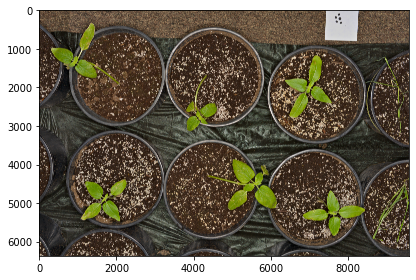

In [36]:
SAVE_RESULTS = False
SHOW_RESULTS = True
path = "../data/semifield-developed-images-trial/NC_2022-03-11/images/NC_3_4_1647017271000.0.jpg"
img_type = "sunflower"
save_path = Path("../Assets/", Path(path).stem)

im = cv2.imread(path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(im)
# Create a Rectangle patch

# plt.axis(False)
plt.tight_layout()
title = "full image"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(im, cv2.COLOR_RGB2BGRA))

# Process domain
First we process contents of a single bounding box. Sometimes a single bbox detection contains multiple plants, especially with early growth stage cotlydons. 

In [28]:
bbox_img = im[4200:5600,1000:2400]
# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(bbox_img)
# Create a Rectangle patch

# plt.axis(False)
plt.tight_layout()
title= "bbox_image"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(bbox_img, cv2.COLOR_RGB2BGRA))

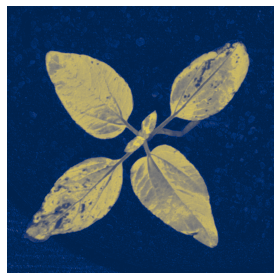

In [29]:
vi0 = make_exg(bbox_img, thresh=True)

fig, ax = plt.subplots()
# Display the image
plt.imshow(vi0, cmap="cividis")
plt.axis(False)
plt.tight_layout()
title= "vi_domain"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(vi0, cv2.COLOR_RGB2BGRA))
        

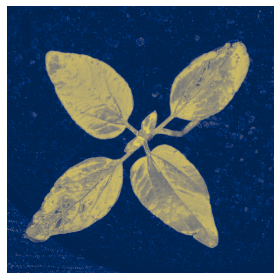

In [30]:
th_vi0 = thresh_vi_funct( vi0)

fig, ax = plt.subplots()
# Display the image
plt.imshow(th_vi0, cmap="cividis")
plt.axis(False)
plt.tight_layout()
title = "thresh_vi_domain"
if SAVE_RESULTS:
    
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(th_vi0, cv2.COLOR_RGB2BGRA))

In [31]:
kmeans = make_kmeans(th_vi0)

fig, ax = plt.subplots()
# Display the image
plt.imshow(kmeans, cmap ="gray")
plt.axis(False)
plt.tight_layout()
title = "kmeans_domain"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(kmeans.astype(np.uint8)*255, cv2.COLOR_RGB2BGRA))

In [32]:
mask = clear_border(kmeans) * 255

fig, ax = plt.subplots()
# Display the image
ax.imshow(mask)
plt.axis(False)
plt.tight_layout()
title= "clear_border_domain"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGRA))

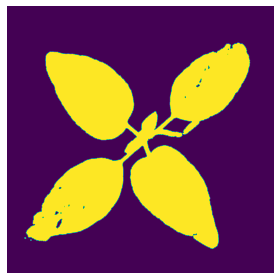

In [33]:
d_e_mask = dilate_erode(mask, kernel_size=2, dil_iters=1, eros_iters=2, hole_fill=False)


fig, ax = plt.subplots()
# Display the image
ax.imshow(d_e_mask)
plt.axis(False)
plt.tight_layout()
title = "dilate_erode_domain"
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}.png", cv2.cvtColor(d_e_mask.astype(np.uint8), cv2.COLOR_RGB2BGRA))

## Second round of processing `process_cutout`

In [34]:
list_cutouts_masks = seperate_components(d_e_mask)
print(len(list_cutouts_masks))

1


[INFO] launching pool using 24 processes...
Cutout 0


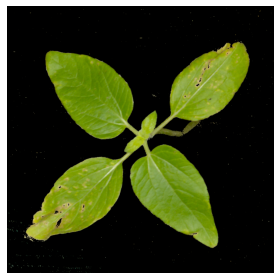

Cutout mask


Cutout


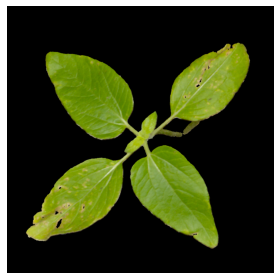

VI


Thresh VI


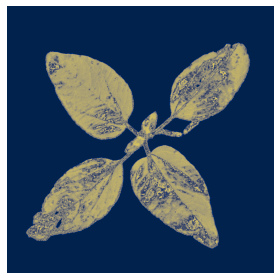

Markers


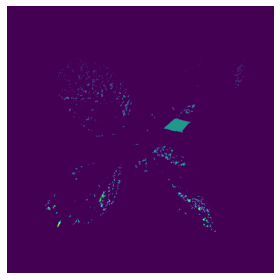

Gradient


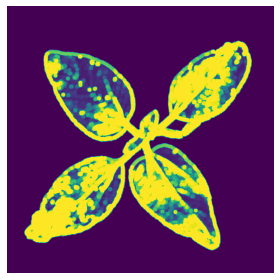

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'drawContours'
> Overload resolution failed:
>  - Can't parse 'contours'. Sequence item with index 0 has a wrong type
>  - Can't parse 'contours'. Sequence item with index 0 has a wrong type


In [195]:

from multiprocessing import Pool
from multiprocessing import cpu_count
import os

cutout = apply_mask(bbox_img, mask, "black")
payloads = []
for idx, cut_mask in enumerate(list_cutouts_masks):
    data = {"cutout_mask": cut_mask,
			"cutout": cutout,
            "original_img":bbox_img,
            "idx":idx}
    
    payloads.append(data)


procs = cpu_count()


# for cut_mask in list_cutouts_masks:
print("[INFO] launching pool using {} processes...".format(procs))
pool = Pool(processes=procs)
pool.map(proc_cutout, payloads)
# close the pool and wait for all processes to finish
print("[INFO] waiting for processes to finish...")
pool.close()
pool.join()
print("[INFO] multiprocessing complete")
    
    


Cutout 0
uint8
Cutout mask
float64


error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


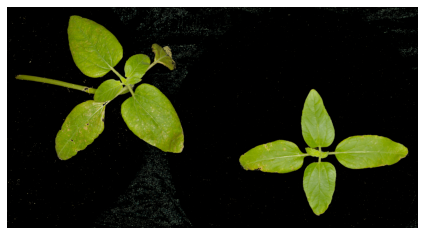

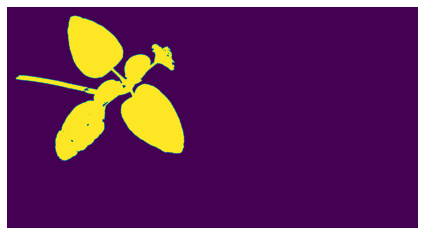

In [250]:
cutout = apply_mask(bbox_img, mask, "black")
cutout = apply_mask(bbox_img, mask, "black")
payloads = []
for idx, cut_mask in enumerate(list_cutouts_masks):
    data = {"cutout_mask": cut_mask,
			"cutout": cutout,
            "idx":idx}
    proc_cutout(data)

### Separate Components using:
`skimage.segmentation.watershed`

In [11]:
from skimage.segmentation import watershed
from skimage.morphology import disk
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.color import label2rgb
from skimage.measure import label
from skimage.exposure import rescale_intensity

# from scipy import ndimage
# from skimage.filters import threshold_multiotsu

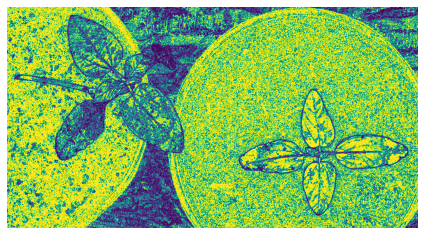

In [12]:
markers = rank.gradient(th_vi, disk(1)) < 12
plt.imshow(markers)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_markers0_domain.png", dpi=300, transparent=True, bbox_inches="tight")

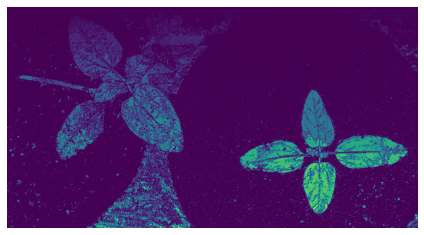

In [13]:
markers = rank.gradient(th_vi, disk(1)) < 12
markers = ndi.label(markers)[0]

plt.imshow(markers)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_marker_domain.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

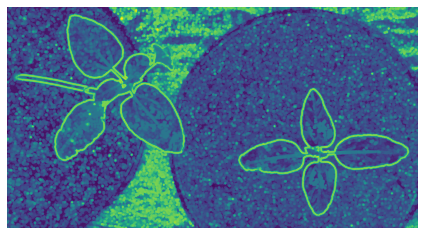

In [25]:
gradient = rank.gradient(th_vi, disk(12))
plt.imshow(gradient)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_gradient_domain.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [ ]:
labels = watershed(gradient, markers)

plt.imshow(labels)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_watershed_domain.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

# Process cutouts

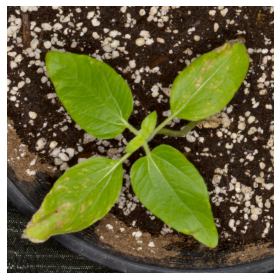

In [83]:
img = bbox_img#im[1500:3500, 3900:5900]
# Create figure and axes

fig, ax = plt.subplots()
# Display the image
ax.imshow(bbox_img)
# Create a Rectangle patch

plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_sample.png", dpi=300, transparent=True, bbox_inches="tight")

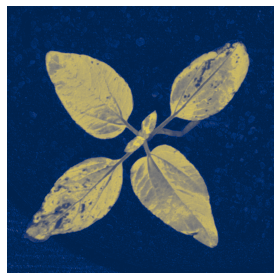

In [84]:
vi = make_exg(img, thresh=True)

plt.imshow(vi, cmap="cividis")
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_vi_idv.png", dpi=300, transparent=True, bbox_inches='tight')

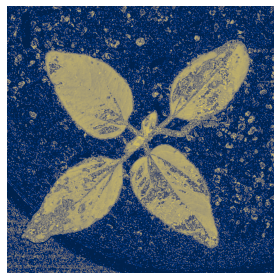

In [85]:
thresh_vi = thresh_vi_funct(vi)
plt.axis(False)
plt.imshow(thresh_vi, cmap="cividis")
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}__thresholding.png", dpi=300, transparent=True, bbox_inches='tight')

Markers


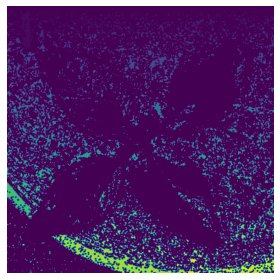

In [81]:
markers = rank.gradient(thresh_vi, disk(4)) < 12
markers = ndi.label(markers)[0]
# Display the image
title = "Markers"
print(title)
fig, ax = plt.subplots()
ax.imshow(markers)
plt.axis(False)
plt.tight_layout()

Gradient


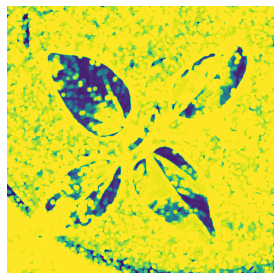

In [82]:
gradient = rank.gradient(thresh_vi, disk(10))
# Display the image
title = "Gradient"
print(title)
fig, ax = plt.subplots()
ax.imshow(gradient)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    cv2.imwrite(f"{save_path}_{img_type}_{title}_cutout_{idx}.png", cv2.cvtColor(gradient, cv2.COLOR_RGB2BGRA))
if SHOW_RESULTS:
    plt.show()

In [78]:
kmeans = make_kmeans(thresh_vi)

plt.imshow(kmeans, cmap ="gray")
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_kmeans.jpg", dpi=300, transparent=True, bbox_inches = "tight")

In [79]:
reduced_mask = reduce_holes(kmeans)

plt.imshow(reduced_mask, cmap="gray")
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_reduced_holes.png", dpi=300, transparent=True, bbox_inches="tight")

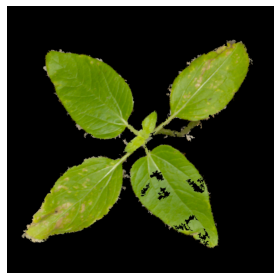

In [80]:
cutout = apply_mask(img, reduced_mask, "black")

plt.imshow(cutout)
plt.axis(False)
plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(f"{save_path}_{img_type}_cutout_apply_mask.png", dpi=300, transparent=True, bbox_inches="tight")

# Using Watershed (not used in pipeline)

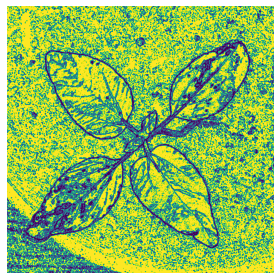

In [64]:
markers = rank.gradient(thresh_vi, disk(1)) < 12
plt.imshow(markers)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_mark0.png", dpi=300, transparent=True, bbox_inches="tight")

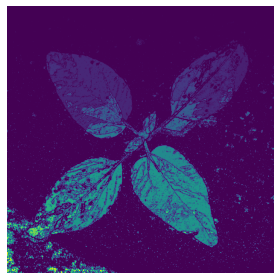

In [65]:
markers = rank.gradient(thresh_vi, disk(1)) < 12
markers = ndi.label(markers)[0]

plt.imshow(markers)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_marker.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [66]:
gradient = rank.gradient(thresh_vi, disk(10))
plt.imshow(gradient)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_grad.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

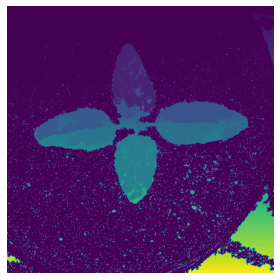

In [47]:
labels = watershed(gradient, markers)

plt.imshow(labels)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_labels_color.png", dpi=300, transparent=True, bbox_inches="tight")


In [49]:
labels = watershed(gradient, markers)
seg1 = label(labels <= 0) 
labels = label2rgb(seg1, image=thresh_vi, bg_label=0)*2.5

plt.imshow(labels)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_labeled.png", dpi=300, transparent=True, bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [51]:
sigma = 0.00000
lb = rescale_intensity(labels, in_range=(-sigma, 1 + sigma),
                         out_range=(0, 1))
mask = np.where(lb <=0.3, 0, 1)

plt.imshow(mask*255)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_masked.png", dpi=300, transparent=True, bbox_inches="tight")

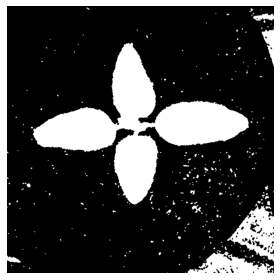

In [52]:
dil_erod_mask = dilate_erode(mask[:,:,0], kernel_size=3, dil_iters=5, eros_iters=5, hole_fill=False)

plt.imshow(dil_erod_mask, cmap="gray")
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_dil_eroded.png", dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [53]:
reduced_mask = reduce_holes(dil_erod_mask * 255) * 255

print(reduced_mask.shape)
print(reduced_mask.max())
print(reduced_mask.dtype)

plt.imshow(reduced_mask, cmap="gray")
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_reduced.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

(2000, 2000)
255
int64


In [54]:
cutout = apply_mask(img, reduced_mask, "black")

plt.imshow(cutout)
plt.axis(False)
plt.tight_layout()
# plt.savefig(f"{save_path}_{img_type}_cutout.png", dpi=300, transparent=True, bbox_inches="tight")
